# Imports & Setup

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/dcec
%ls

/content/drive/My Drive/Colab Notebooks/dcec
dcec-replicate.ipynb  dec/  model.h5  models/  results/  weights/


In [0]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from pathlib import Path
from keras.datasets import mnist
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import classification_report
from models.dcec import DCEC
from sklearn.manifold import TSNE
import tensorflow as tf
import scipy
import seaborn as sns
import pickle

from sklearn.metrics.cluster import contingency_matrix

from keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from keras.models import Sequential, Model


import itertools
import os
from tqdm import tqdm

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!nvidia-smi

Sun May 31 11:51:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
img_rows, img_cols = 28, 28
batch_size = 256
(mnist_train_data, mnist_train_labels), (mnist_test_data, mnist_test_labels) = mnist.load_data()
mnist_train_data = mnist_train_data.reshape(mnist_train_data.shape[0], img_rows, img_cols, 1)
mnist_train_data = mnist_train_data.astype('float32')
mnist_train_data /= 255
mnist_test_data = mnist_test_data.reshape(mnist_test_data.shape[0], img_rows, img_cols, 1)
mnist_test_data = mnist_test_data.astype('float32')
mnist_test_data /= 255
print(f'MNIST train shape:  {mnist_train_data.shape}')
print(f'MNIST validation shape: {mnist_test_data.shape}')

11493376/11490434 [==============================] - 1s 0us/step
MNIST train shape:  (60000, 28, 28, 1)
MNIST validation shape: (10000, 28, 28, 1)


# Setup Model

In [0]:
def CAE(input_shape=(28, 28, 1), filters=[32, 64, 128, 10], use_norm=False):
    model = keras.models.Sequential()
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    model.add(Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape))
    model.add(Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2'))
    model.add(Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3'))
    model.add(Flatten())
    
    if use_norm:
      model.add(Dense(units=filters[3], name='dense1'))
      model.add(keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=0), name='embedding'))
    else:
      model.add(Dense(units=filters[3], name='embedding'))

    model.add(Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu'))
    model.add(Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2])))
    model.add(Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3'))
    model.add(Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2'))
    model.add(Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1'))
    # model.summary()
    return model



# Replication of Clustering

In [0]:
def get_clustering_model(use_l2, train=False, epochs=200, batch_size=256):
  if train:
    checkpoint = ModelCheckpoint("weights/dcec_best_model.hdf5", monitor='loss', verbose=1,
        save_best_only=True, mode='auto', period=50)
    
    cae = CAE(use_norm=use_l2)
    cae.compile(optimizer='adam', loss='mse')
    
    cae.fit(mnist_train_data, 
            mnist_train_data, 
            batch_size=batch_size, 
            epochs=epochs,
            verbose=1,
            validation_data=(mnist_test_data, mnist_test_data))
            # callbacks=[checkpoint])
    
    l2 = "withl2" if use_l2 else "nol2" 
    cae.save_weights(f"weights/clustering_final_model_{epochs}_{batch_size}_{l2}.h5")
  else:
    cae.load_weights(f"weights/clustering_final_model_{epochs}_{batch_size}_{l2}.h5")
  return cae

# SETTINGS
BATCH_SIZE = 256
EPOCHS = 200

## Model without $L_2$ Norm 

In [0]:
def cluster_emb(emb, n_clusters=10):
  clf = KMeans(n_clusters=n_clusters, init="k-means++", n_init=30, max_iter=2e4, tol=0.0001)
  cluster_dist = clf.fit_transform(emb)
  labels = clf.predict(emb)
  return labels, cluster_dist, clf


def m(y_true, y_pred):
  """Find a mapping from ground truth to kmeans labels"""
  cm = contingency_matrix(y_pred, y_true)
  # print(cm)
  # print(np.argmax(cm, axis=1))
  _, assignment = scipy.optimize.linear_sum_assignment(-cm)
  print(assignment)
  return np.asarray([assignment[l] for l in y_pred])


def plot_tnse(data, titles, y_true, layout, selection_size=1000):
  tsne_selection = np.random.permutation(len(embeddings))[:selection_size]
  for i, ((_d, _y_pred), _t), in enumerate(zip(data, titles)):
    tsne_emb = TSNE(n_components=2).fit_transform(_d[tsne_selection])
    labels_m = m(y_true, _y_pred)
    plt.subplot(*layout, i+1)
    g = sns.scatterplot(tsne_emb[:, 0], tsne_emb[:, 1], hue=labels[tsne_selection], legend="full", palette="Paired").set_title(f"TNSE of {_t} (N={selection_size})")
    

def report(y_true, labels_unmapped):
  mapping = m(y_true, labels_unmapped)
  print(classification_report(y_true, mapping))
  print("Accuracy: ", (y_true == mapping).mean())


def get_emb(_model, data):
  encoder = keras.Model(inputs=_model.input, outputs=_model.get_layer(name='embedding').output)
  return encoder.predict(data)

def compute_normality(C, emb):
  norm = emb @ (C.T / np.linalg.norm(C, ord=2, axis=1))
  # print(norm)
  return norm.max(axis=1)

def plot_losses(_model, title="Model Loss"):
  history = _model.history
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [0]:
#@title
m_no_l2 = get_clustering_model(use_l2=False, train=True, epochs=EPOCHS, batch_size=BATCH_SIZE)

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 3s 47us/step - loss: 0.0453 - val_loss: 0.0233
Epoch 2/200
60000/60000 [==============================] - 3s 43us/step - loss: 0.0201 - val_loss: 0.0179
Epoch 3/200
60000/60000 [==============================] - 3s 42us/step - loss: 0.0172 - val_loss: 0.0162
Epoch 4/200
60000/60000 [==============================] - 3s 43us/step - loss: 0.0159 - val_loss: 0.0153
Epoch 5/200
60000/60000 [==============================] - 3s 43us/step - loss: 0.0150 - val_loss: 0.0148
Epoch 6/200
60000/60000 [==============================] - 3s 43us/step - loss: 0.0144 - val_loss: 0.0143
Epoch 7/200
60000/60000 [==============================] - 3s 43us/step - loss: 0.0139 - val_loss: 0.0137
Epoch 8/200
60000/60000 [==============================] - 3s 43us/step - loss: 0.0136 - val_loss: 0.0134
Epoch 9/200
60000/60000 [==============================] - 3s 43us/step - loss: 0.0132 - val_loss: 0.0

## Model with $L_2$ Norm

In [0]:
m_l2 = get_clustering_model(use_l2=True, train=True, epochs=EPOCHS, batch_size=BATCH_SIZE)

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 3s 49us/step - loss: 0.0496 - val_loss: 0.0514
Epoch 2/200
60000/60000 [==============================] - 3s 43us/step - loss: 0.0264 - val_loss: 0.0402
Epoch 3/200
60000/60000 [==============================] - 3s 44us/step - loss: 0.0225 - val_loss: 0.0311
Epoch 4/200
60000/60000 [==============================] - 3s 43us/step - loss: 0.0200 - val_loss: 0.0320
Epoch 5/200
60000/60000 [==============================] - 3s 43us/step - loss: 0.0187 - val_loss: 0.0285
Epoch 6/200
60000/60000 [==============================] - 3s 43us/step - loss: 0.0176 - val_loss: 0.0262
Epoch 7/200
60000/60000 [==============================] - 3s 44us/step - loss: 0.0168 - val_loss: 0.0260
Epoch 8/200
60000/60000 [==============================] - 3s 44us/step - loss: 0.0163 - val_loss: 0.0252
Epoch 9/200
60000/60000 [==============================] - 3s 43us/step - loss: 0.0158 - val_loss: 0.0

In [0]:
%ls -l weights/clustering*

-rw------- 1 root root 1134464 May 31 12:17 weights/clustering_final_model_200_256_nol2.h5
-rw------- 1 root root 1135296 May 31 12:26 weights/clustering_final_model_200_256_withl2.h5


## Plot losses

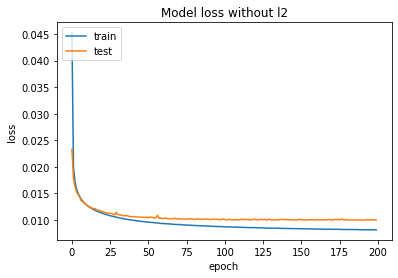

In [0]:
plot_losses(m_no_l2, title="Model loss without l2")

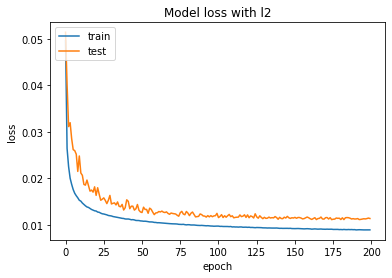

In [0]:
plot_losses(m_l2, title="Model loss with l2")

In [0]:
# Get emb with l2
encoder = keras.Model(inputs=m_l2.input, outputs=cae_l2.get_layer(name='embedding').output)
embeddings = encoder.predict(mnist_test_data) 

# Get emb without l2
encoder_no_l2 = keras.Model(inputs=m_no_l2.input, outputs=cae.get_layer(name='embedding').output)
embeddings_no_l2 = encoder_no_l2.predict(mnist_test_data)


# Labels
labels, clusters, _ = cluster_emb(embeddings)
labels_no_l2, cluster_no_l2, _ = cluster_emb(embeddings_no_l2)

In [0]:
print("REPORT WITH L2")
report(mnist_test_labels, labels)

REPORT WITH L2
[[  1   0  15  14   7   3   0 935   9 286]
 [ 20   1  13   0  12   9 857   0   1   1]
 [  2   1  21  22   1  11   1   0 894  12]
 [  0   5 941  14   3   0   0  26   1   2]
 [  0 668   3   2  11   2   6   8   1   9]
 [  2   0   3   3 914   1   2  46  11 654]
 [948   0  18   2   0  17  28   1  12  18]
 [  5   0   9 944   0 213   0   0  37  13]
 [  1 459   8   0  34   7   5  12   4  12]
 [  1   1   1   9   0 629  59   0   4   2]]
[7 6 8 2 1 4 0 3 9 5]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       980
           1       0.94      0.59      0.72      1135
           2       0.95      0.91      0.93      1032
           3       0.77      0.93      0.85      1010
           4       0.56      0.93      0.70       982
           5       0.89      0.71      0.79       892
           6       0.94      0.89      0.92       958
           7       0.74      0.91      0.81      1028
           8       0.93      0.92      0.92  

In [0]:
print("REPORT WITHOUT L2")
report(mnist_test_labels, labels_no_l2)

REPORT WITHOUT L2
[[ 960    0   18    0    0    6   21    1    2   10]
 [   1 1128    6    1    5    5   23   39    5   14]
 [   1    0    3    3  564    1    2   19   10  441]
 [   8    1   40   33    0   13    5    2  922   14]
 [   0    1    7  960    0  105    0    0    7    8]
 [   7    0    9    0    6   14  868    0    6    0]
 [   1    0   12    7    0    1    0  917    5   10]
 [   2    0    0    2    0  737   38    0    3    0]
 [   0    4  935    3    0    0    0   12    0    0]
 [   0    1    2    1  407   10    1   38   14  512]]
[0 1 4 8 3 6 7 5 2 9]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.92      0.99      0.96      1135
           2       0.98      0.91      0.94      1032
           3       0.88      0.95      0.92      1010
           4       0.54      0.57      0.56       982
           5       0.94      0.83      0.88       892
           6       0.95      0.91      0.93       

[[  1   0  15  14   7   3   0 935   9 286]
 [ 20   1  13   0  12   9 857   0   1   1]
 [  2   1  21  22   1  11   1   0 894  12]
 [  0   5 941  14   3   0   0  26   1   2]
 [  0 668   3   2  11   2   6   8   1   9]
 [  2   0   3   3 914   1   2  46  11 654]
 [948   0  18   2   0  17  28   1  12  18]
 [  5   0   9 944   0 213   0   0  37  13]
 [  1 459   8   0  34   7   5  12   4  12]
 [  1   1   1   9   0 629  59   0   4   2]]
[7 6 8 2 1 4 0 3 9 5]
[[ 960    0   18    0    0    6   21    1    2   10]
 [   1 1128    6    1    5    5   23   39    5   14]
 [   1    0    3    3  564    1    2   19   10  441]
 [   8    1   40   33    0   13    5    2  922   14]
 [   0    1    7  960    0  105    0    0    7    8]
 [   7    0    9    0    6   14  868    0    6    0]
 [   1    0   12    7    0    1    0  917    5   10]
 [   2    0    0    2    0  737   38    0    3    0]
 [   0    4  935    3    0    0    0   12    0    0]
 [   0    1    2    1  407   10    1   38   14  512]]
[0 1 4 8 3 6 7 5

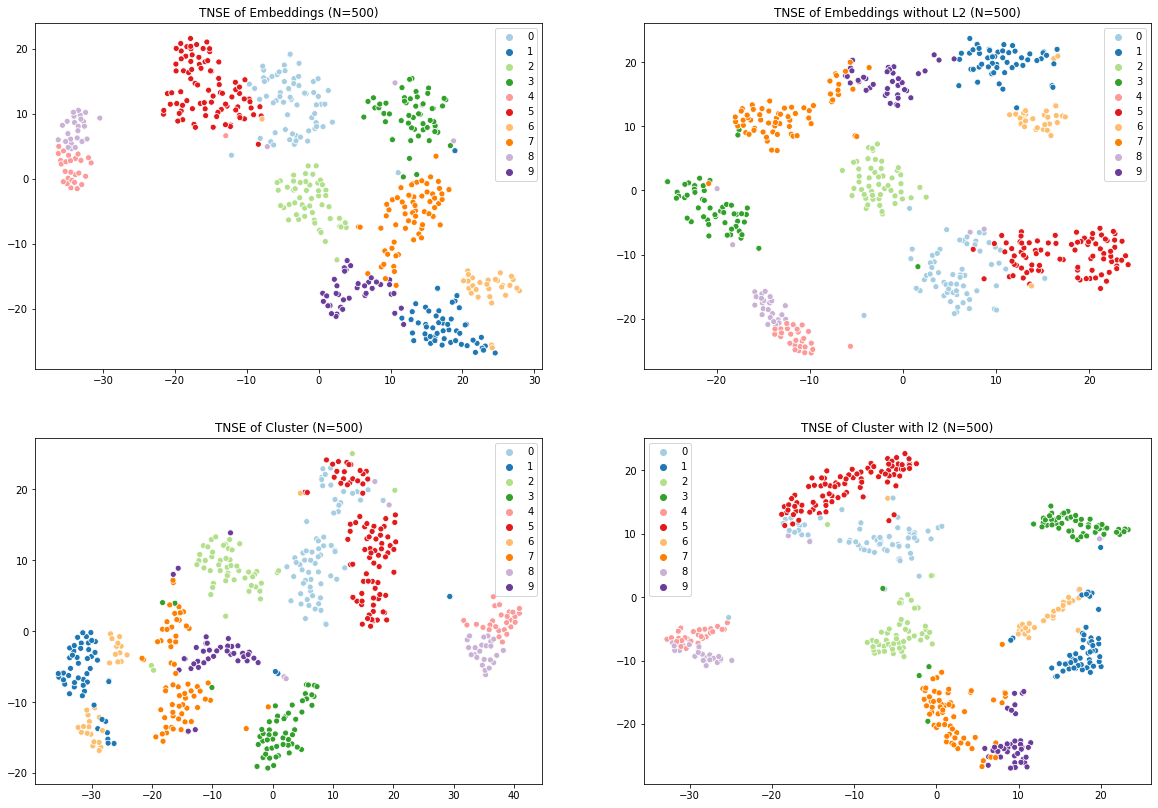

In [0]:
data = [(embeddings, labels), (embeddings_no_l2, labels_no_l2), (clusters, labels), (cluster_no_l2, labels_no_l2)]
titles = ['Embeddings', 'Embeddings without L2' , 'Cluster', 'Cluster with l2']

plt.figure(figsize=(20,14))
plot_tnse(data, titles, mnist_test_labels, (2,2), 500)
plt.show()

NameError: ignored

# Anomaly Detection



Take a random digit and drop 10% in the train set

In [0]:
anomaly_digit = 3 #np.random.randint(10)
print(f"Using {anomaly_digit} as anomaly dropping 90% of the training samples")

anomalies = mnist_train_labels == anomaly_digit
selection = np.ones(len(mnist_train_labels), dtype=np.bool)
selection[anomalies] = 0
_selection_anomalies = np.random.choice(len(mnist_train_labels), int(anomalies.sum() * 0.10), replace=False, p=anomalies / anomalies.sum())
selection[_selection_anomalies] = 1

Using 3 as anomaly dropping 90% of the training samples


In [0]:
anomaly_train_data = mnist_train_data[selection]
anomaly_train_labels = mnist_train_labels[selection]

In [0]:
anomaly_train_data = mnist_train_data[selection]
anomaly_train_labels = mnist_train_labels[selection]

In [0]:
cea_l2_anomaly = CAE(use_norm=True)
cea_l2_anomaly.compile(optimizer='adam', loss='mse')
cea_l2_anomaly.fit(anomaly_train_data, anomaly_train_data,   
          batch_size=batch_size, 
          epochs=200,
          verbose=1)

In [0]:
emb = get_emb(cea_l2_anomaly, mnist_train_data)
labels_a, clusters_a, clf_a = cluster_emb(emb, n_clusters=9)


(array([  83.,  608., 1850., 2276., 2245., 1537.,  915.,  414.,   67.,
           5.]),
 array([0.0544037 , 0.13802458, 0.22164547, 0.30526638, 0.38888726,
        0.47250816, 0.55612904, 0.63974994, 0.72337085, 0.8069917 ,
        0.8906126 ], dtype=float32),
 <a list of 10 Patch objects>)

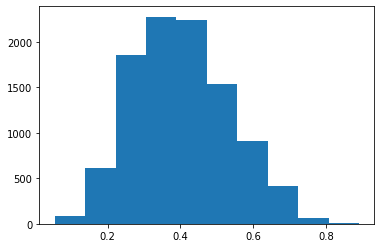

In [0]:
plt.hist(normality)

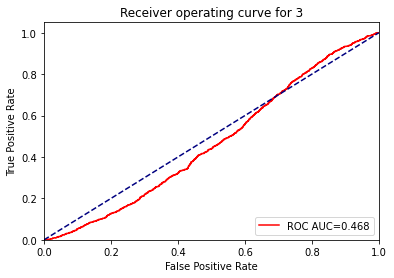

In [0]:

fpr, tpr, thresholds = metrics.roc_curve(mnist_test_labels == anomaly_digit, 1-normality, pos_label=1)
auc_digit = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC AUC={auc_digit:0.3f}", c="r")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating curve for {anomaly_digit}')
plt.legend(loc="lower right")
plt.show()

In [0]:
def detect_anomaly(anomaly_digit):
  anomalies = mnist_train_labels == anomaly_digit
  selection = np.ones(len(mnist_train_labels), dtype=np.bool)
  selection[anomalies] = 0
  _selection_anomalies = np.random.choice(len(mnist_train_labels), int(anomalies.sum() * 0.10), replace=False, p=anomalies / anomalies.sum())
  selection[_selection_anomalies] = 1

  anomaly_train_data = mnist_train_data[selection]
  anomaly_train_labels = mnist_train_labels[selection]

  anomaly_train_data = mnist_train_data[selection]
  anomaly_train_labels = mnist_train_labels[selection]

  cea_l2_anomaly = CAE(use_norm=True)
  cea_l2_anomaly.compile(optimizer='adam', loss='mse')
  cea_l2_anomaly.fit(anomaly_train_data, anomaly_train_data,   
          batch_size=batch_size, 
          epochs=1,
          verbose=1)
  
  emb = get_emb(cea_l2_anomaly, mnist_train_data)
  labels_a, clusters_a, clf_a = cluster_emb(emb, n_clusters=9)

  normality = compute_normality(clf_a.cluster_centers_, get_emb(cea_l2_anomaly, mnist_test_data))

  fpr, tpr, thresholds = metrics.roc_curve(mnist_test_labels == anomaly_digit, 1-normality, pos_label=1)
  auc_digit = metrics.auc(fpr, tpr)
  plt.plot(fpr, tpr, label=f"ROC AUC={auc_digit:0.3f}", c="r")
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver operating curve for {anomaly_digit}')
  plt.legend(loc="lower right")
  plt.show()

plt.figure(figsize=(10,30))
for i in range(0, 10):
  plt.subplot(2, 5, i+1)
  detect_anomaly(d)

# Full replication of DCEC results

## Experimental setup
- Create anomaly by removing 10% one digit on the training set, leave the test set unchanged.
- 10 fold-CV for each digit.

In [0]:
def model_filename(l2, digit, fold, epochs, batch_size):
  norm = "with_l2" if l2 else "no_l2"
  return f"weights/d{digit}_{norm}_f{fold}_e{epochs}_b{batch_size}.h5"


def fn_to_params(fn):
  return fn.split("_")[0][1:], fn.split("_")[1][1:], fn.split("_")[2][1:], fn.split("_")[3][1:], fn.split("_")[4][1:]


def train_models():
  epochs = 200
  batch_size = 256  
  N = len(mnist_train_data)
  fold_size = N // 10
  for with_l2, anomaly_digit, fold in tqdm(itertools.product([True, False], range(0, 10), range(0, 10))):
    perm = np.random.RandomState(seed=42).permutation(N) # set the seed for reproducability of folds in case runtime crashes; should affect results.
    fn = model_filename(with_l2, anomaly_digit, fold, epochs, batch_size)
    if os.path.exists(fn):
      print(f"{fn} already exists continueing")
    else:
      print(f"Training A:{anomaly_digit}, Fold:{fold}, with L2:{with_l2}")
    start, end = fold_size*fold, fold_size*(fold+1)
    X_train, y_train = mnist_train_data[perm[start:end]], mnist_train_labels[perm[start:end]]

    cae = CAE(use_norm=with_l2)
    cae.compile(optimizer="adam", loss="mse")
    cae.fit(X_train, X_train, batch_size=batch_size, 
          epochs=epochs,
          verbose=0)
    cae.save_weights(fn)


def test_models(anomaly_digit, fold, epochs, batch_size, with_l2):
  def compute_metrics(y_true, y_pred):
    pass

  weights_fn = model_filename(with_l2, anomaly_digit, fold, epochs, batch_size)

  # print(f"testing for {weights_fn}")
  cae = CAE(use_norm=with_l2)
  cae.compile(optimizer="adam", loss="mse")
  cae.load_weights(weights_fn)

  # Rebuild fold
  N = len(mnist_train_data)
  fold_size = N // 10
  perm = np.random.RandomState(seed=42).permutation(N)
  start, end = fold_size*fold, fold_size*(fold+1)
  X_train, y_train = mnist_train_data[perm[start:end]], mnist_train_labels[perm[start:end]]

  # Compute embeddings
  embeddings = get_emb(cae, X_train)
  embeddings_test = get_emb(cae, mnist_test_data)

  # Cluster
  labels_ana, clusters_ana, clf_ana = cluster_emb(embeddings, n_clusters=9)
  
  # Compute normality measure toward clusters
  normality = compute_normality(clf_ana.cluster_centers_, embeddings_test)

  fpr, tpr, _ = metrics.roc_curve(mnist_test_labels == anomaly_digit, 1-normality, pos_label=1)
  auc = metrics.auc(fpr, tpr)

  return fpr, tpr, auc

In [0]:
results = {}
for with_l2, anomaly_digit, fold in tqdm(itertools.product([True, False], range(0, 10), range(0, 10))):
  results[(with_l2, anomaly_digit, fold)] = test_models(anomaly_digit, fold, 200, 256, with_l2)

# results 

if not os.path.exists('results/results_replication_3.pickle'):
  with open('results/results_replication.pickle', 'wb') as f:
    pickle.dump(results, f)
else:
  print("A file with that name already exists opening it")
  # with open('results/results_replication.pickle', 'rb') as f:
  #   results = pickle.load(f)

200it [17:25,  5.23s/it]


In [0]:
df_results = pd.DataFrame.from_dict(results, orient="index", columns=["fpr", "tpr", "auc"])
df_results.index = pd.MultiIndex.from_tuples(df_results.index)
df_results = df_results.unstack(level=-1) # unstack by fold
df_results['auc'].mean(1)

False  0    0.248955
       1    0.700608
       2    0.442168
       3    0.470308
       4    0.482904
       5    0.596275
       6    0.408755
       7    0.491713
       8    0.634032
       9    0.551765
True   0    0.454057
       1    0.201678
       2    0.538456
       3    0.604829
       4    0.381469
       5    0.567805
       6    0.383631
       7    0.405982
       8    0.751718
       9    0.726346
dtype: float64

In [0]:
df_results.loc[(True, 0)]

fpr  0    [0.0, 0.00011086474501108647, 0.00343680709534...
     1    [0.0, 0.00011086474501108647, 0.01430155210643...
     2    [0.0, 0.00011086474501108647, 0.00277161862527...
     3    [0.0, 0.00011086474501108647, 0.00044345898004...
     4    [0.0, 0.00011086474501108647, 0.01629711751662...
     5    [0.0, 0.00011086474501108647, 0.00554323725055...
     6    [0.0, 0.00011086474501108647, 0.00110864745011...
     7    [0.0, 0.00011086474501108647, 0.00254988913525...
     8    [0.0, 0.00011086474501108647, 0.00110864745011...
     9    [0.0, 0.00011086474501108647, 0.00476718403547...
tpr  0    [0.0, 0.0, 0.0, 0.0010204081632653062, 0.00102...
     1    [0.0, 0.0, 0.0, 0.0010204081632653062, 0.00102...
     2    [0.0, 0.0, 0.0, 0.0010204081632653062, 0.00102...
     3    [0.0, 0.0, 0.0, 0.0010204081632653062, 0.00102...
     4    [0.0, 0.0, 0.0, 0.0010204081632653062, 0.00102...
     5    [0.0, 0.0, 0.0, 0.0010204081632653062, 0.00102...
     6    [0.0, 0.0, 0.0, 0.001020408163

In [0]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((
          self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [0]:
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.cluster import KMeans


In [0]:
epochs = 100

cae = CAE()
cae.compile(optimizer='adam', loss='mse')



if False:
  checkpoint = ModelCheckpoint("weights/dcec_best_model.hdf5", monitor='loss', verbose=1,
      save_best_only=True, mode='auto', period=50)

  cae.fit(mnist_train_data, 
          mnist_train_data, 
          batch_size=batch_size, 
          epochs=epochs,
          verbose=1)
          # callbacks=[checkpoint])

  cae.save_weights(f"weights/cae_final_model_{epochs}_{batch_size}.h5")
else:
  cae.load_weights(f"weights/d4_with_l2_f1_e200_b256.h5")

n_clusters = 9

hidden = cae.get_layer(name='embedding').output
encoder = Model(inputs=cae.input, outputs=hidden)

# Define DCEC model
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(hidden)
model = Model(inputs=cae.input,
                    outputs=[clustering_layer, cae.output])

TypeError: ignored

In [0]:
%ls weights/

d0_no_l2_f0_e200_b256.h5    d5_no_l2_f0_e200_b256.h5
d0_no_l2_f1_e200_b256.h5    d5_no_l2_f1_e200_b256.h5
d0_no_l2_f2_e200_b256.h5    d5_no_l2_f2_e200_b256.h5
d0_no_l2_f3_e200_b256.h5    d5_no_l2_f3_e200_b256.h5
d0_no_l2_f4_e200_b256.h5    d5_no_l2_f4_e200_b256.h5
d0_no_l2_f5_e200_b256.h5    d5_no_l2_f5_e200_b256.h5
d0_no_l2_f6_e200_b256.h5    d5_no_l2_f6_e200_b256.h5
d0_no_l2_f7_e200_b256.h5    d5_no_l2_f7_e200_b256.h5
d0_no_l2_f8_e200_b256.h5    d5_no_l2_f8_e200_b256.h5
d0_no_l2_f9_e200_b256.h5    d5_no_l2_f9_e200_b256.h5
d0_with_l2_f0_e200_b256.h5  d5_with_l2_f0_e200_b256.h5
d0_with_l2_f1_e200_b256.h5  d5_with_l2_f1_e200_b256.h5
d0_with_l2_f2_e200_b256.h5  d5_with_l2_f2_e200_b256.h5
d0_with_l2_f3_e200_b256.h5  d5_with_l2_f3_e200_b256.h5
d0_with_l2_f4_e200_b256.h5  d5_with_l2_f4_e200_b256.h5
d0_with_l2_f5_e200_b256.h5  d5_with_l2_f5_e200_b256.h5
d0_with_l2_f6_e200_b256.h5  d5_with_l2_f6_e200_b256.h5
d0_with_l2_f7_e200_b256.h5  d5_with_l2_f7_e200_b256.h5
d0_with_l2_f8_e200_b256.h5  d5

In [0]:
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.cluster import KMeans
# import metrics
# from ConvAE import CAE


import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

class PlaceHolder:
  nmi = normalized_mutual_info_score
  ari = adjusted_rand_score


  def acc(self, y_true, y_pred):
      """
      Calculate clustering accuracy. Require scikit-learn installed
      # Arguments
          y: true labels, numpy.array with shape `(n_samples,)`
          y_pred: predicted labels, numpy.array with shape `(n_samples,)`
      # Return
          accuracy, in [0,1]
      """
      y_true = y_true.astype(np.int64)
      assert y_pred.size == y_true.size
      D = max(y_pred.max(), y_true.max()) + 1
      w = np.zeros((D, D), dtype=np.int64)
      for i in range(y_pred.size):
          w[y_pred[i], y_true[i]] += 1
      from sklearn.utils.linear_assignment_ import linear_assignment
      ind = linear_assignment(w.max() - w)
      return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

metrics = PlaceHolder()

class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DCEC(object):
    def __init__(self,
                 input_shape,
                 filters=[32, 64, 128, 10],
                 n_clusters=10,
                 alpha=1.0):

        super(DCEC, self).__init__()

        self.n_clusters = n_clusters
        self.input_shape = input_shape
        self.alpha = alpha
        self.pretrained = False
        self.y_pred = []

        self.cae = CAE(input_shape, filters)
        hidden = self.cae.get_layer(name='embedding').output
        self.encoder = Model(inputs=self.cae.input, outputs=hidden)

        # Define DCEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(hidden)
        self.model = Model(inputs=self.cae.input,
                           outputs=[clustering_layer, self.cae.output])

    def pretrain(self, x, batch_size=256, epochs=200, optimizer='adam', save_dir='results/temp'):
        print('...Pretraining...')
        self.cae.compile(optimizer=optimizer, loss='mse')
        from keras.callbacks import CSVLogger
        csv_logger = CSVLogger(args.save_dir + '/pretrain_log.csv')

        # begin training
        t0 = time()
        self.cae.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=[csv_logger])
        print('Pretraining time: ', time() - t0)
        self.cae.save(save_dir + '/pretrain_cae_model.h5')
        print('Pretrained weights are saved to %s/pretrain_cae_model.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights_path):
        self.model.load_weights(weights_path)

    def extract_feature(self, x):  # extract features from before clustering layer
        return self.encoder.predict(x)

    def predict(self, x):
        q, _ = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, loss=['kld', 'mse'], loss_weights=[1, 1], optimizer='adam'):
        self.model.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer)

    def fit(self, x, y=None, batch_size=256, maxiter=2e4, tol=1e-3,
            update_interval=140, cae_weights=None, save_dir='./results/temp'):

        print('Update interval', update_interval)
        save_interval = x.shape[0] / batch_size * 5
        print('Save interval', save_interval)

        # Step 1: pretrain if necessary
        t0 = time()
        if not self.pretrained and cae_weights is None:
            print('...pretraining CAE using default hyper-parameters:')
            print('   optimizer=\'adam\';   epochs=200')
            self.pretrain(x, batch_size, save_dir=save_dir)
            self.pretrained = True
        elif cae_weights is not None:
            self.cae.load_weights(cae_weights)
            print('cae_weights is loaded successfully.')

        # Step 2: initialize cluster centers using k-means
        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        self.y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(self.y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 3: deep clustering
        # logging file
        import csv, os
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        logfile = open(save_dir + '/dcec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'L', 'Lc', 'Lr'])
        logwriter.writeheader()

        t2 = time()
        loss = [0, 0, 0]
        index = 0
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q, _ = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                self.y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(metrics.acc(y, self.y_pred), 5)
                    nmi = np.round(metrics.nmi(y, self.y_pred), 5)
                    ari = np.round(metrics.ari(y, self.y_pred), 5)
                    loss = np.round(loss, 5)
                    logdict = dict(iter=ite, acc=acc, nmi=nmi, ari=ari, L=loss[0], Lc=loss[1], Lr=loss[2])
                    logwriter.writerow(logdict)
                    print('Iter', ite, ': Acc', acc, ', nmi', nmi, ', ari', ari, '; loss=', loss)

                # check stop criterion
                delta_label = np.sum(self.y_pred != y_pred_last).astype(np.float32) / self.y_pred.shape[0]
                y_pred_last = np.copy(self.y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            if (index + 1) * batch_size > x.shape[0]:
                loss = self.model.train_on_batch(x=x[index * batch_size::],
                                                 y=[p[index * batch_size::], x[index * batch_size::]])
                index = 0
            else:
                loss = self.model.train_on_batch(x=x[index * batch_size:(index + 1) * batch_size],
                                                 y=[p[index * batch_size:(index + 1) * batch_size],
                                                    x[index * batch_size:(index + 1) * batch_size]])
                index += 1

            # save intermediate model
            if ite % save_interval == 0:
                # save DCEC model checkpoints
                print('saving model to:', save_dir + '/dcec_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/dcec_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/dcec_model_final.h5')
        self.model.save_weights(save_dir + '/dcec_model_final.h5')
        t3 = time()
        print('Pretrain time:  ', t1 - t0)
        print('Clustering time:', t3 - t1)
        print('Total time:     ', t3 - t0)


if __name__ == "__main__":
    # setting the hyper parameters
    import argparse
    parser = argparse.ArgumentParser(description='train')
    parser.add_argument('dataset', default='mnist', choices=['mnist', 'usps', 'mnist-test'])
    parser.add_argument('--n_clusters', default=10, type=int)
    parser.add_argument('--batch_size', default=256, type=int)
    parser.add_argument('--maxiter', default=2e4, type=int)
    parser.add_argument('--gamma', default=0.1, type=float,
                        help='coefficient of clustering loss')
    parser.add_argument('--update_interval', default=140, type=int)
    parser.add_argument('--tol', default=0.001, type=float)
    parser.add_argument('--cae_weights', default=None, help='This argument must be given')
    parser.add_argument('--save_dir', default='results/temp')
    # args = parser.parse_args()
    print(args)

    args = {}
    args['dataset'] = 'mnist'
    args['n_clusters'] = 9
    args['batch_size'] = 256
    args['maxiter'] = 2e4
    args['gamma'] = 0.1
    args['update_interval'] = 140
    args['tol'] = 0.001
    args['cae_weights'] = 'weights/d4_with_l2_f1_e200_b256.h5'
    args['save_dir'] = 'dec'

    import os
    if not os.path.exists(args['save_dir']):
        os.makedirs(args['save_dir'])



    x, y = mnist_train_data, mnist_train_labels


    # prepare the DCEC model
    dcec = DCEC(input_shape=x.shape[1:], filters=[32, 64, 128, 10], n_clusters=args['n_clusters'])
    # plot_model(dcec.model, to_file=args.save_dir + '/dcec_model.png', show_shapes=True)
    dcec.model.summary()

    # begin clustering.
    optimizer = 'adam'
    dcec.compile(loss=['kld', 'mse'], loss_weights=[args['gamma'], 1], optimizer=optimizer)
    dcec.fit(x, y=y, tol=args['tol'], maxiter=args['maxiter'],
             update_interval=args['update_interval'],
             save_dir=args['save_dir'],
             cae_weights=args['cae_weights'])
    y_pred = dcec.y_pred
    print('acc = %.4f, nmi = %.4f, ari = %.4f' % (metrics.acc(y, y_pred), metrics.nmi(y, y_pred), metrics.ari(y, y_pred)))

{'dataset': 'mnist', 'n_clusters': 9, 'batch_size': 256, 'maxiter': 20000.0, 'gamma': 0.1, 'update_interval': 140, 'tol': 0.001, 'cae_weights': 'weights/d4_with_l2_f1_e200_b256.h5', 'save_dir': 'dec'}
Model: "model_818"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1_input (InputLayer)        (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 32)   832         conv1_input[0][0]                
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 7, 7, 64)     51264       conv1[0][0]                      
_______________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


ValueError: ignored

In [0]:
args.batch_size

AttributeError: ignored